In [10]:
# Import PySpark instead of pandas
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
from pyspark.sql.types import *
import matplotlib.pyplot as plt
import numpy as np
import json
import pandas as pd

# Initialize Spark
spark = SparkSession.builder \
    .appName("FraudDetection") \
    .master("local[2]") \
    .getOrCreate()

spark.sparkContext.setLogLevel("WARN")
print(f"✓ Spark {spark.version} initialized")

# Load fraud dataset
df = spark.read.csv('../data/transactions_data.csv', header=True, inferSchema=True)

# Load fraud labels
with open('../data/train_fraud_labels.json', 'r') as f:
        raw_json_data = json.load(f)

transaction_labels_dict = raw_json_data['target']
train_fraud_labels = pd.Series(transaction_labels_dict).reset_index()
train_fraud_labels.columns = ['transaction_id', 'is_fraud']
train_fraud_labels['transaction_id'] = pd.to_numeric(train_fraud_labels['transaction_id'])
train_fraud_labels['is_fraud'] = train_fraud_labels['is_fraud'].map({'Yes': 1, 'No': 0})

# Convert fraud labels to Spark DataFrame and join
fraud_df = spark.createDataFrame(train_fraud_labels, ["transaction_id", "is_fraud"])

# Create sample and add fraud labels
sample_df = df.limit(50000)
print(f"Dataset: {sample_df.count()} transactions")


# Add row numbers and join with fraud labels
sample_df = sample_df.withColumn("row_id", monotonically_increasing_id())
sample_df = sample_df.join(fraud_df, sample_df.id == fraud_df.transaction_id, "left").fillna(0, ["is_fraud"])

# Check fraud rate
fraud_count = sample_df.filter(col("is_fraud") == 1).count()
total_count = sample_df.count()
fraud_rate = fraud_count / total_count
print(f"Fraud rate: {fraud_rate:.1%}")

sample_df.show(5)

✓ Spark 3.5.3 initialized


Dataset: 50000 transactions


25/08/12 12:28:24 WARN TaskSetManager: Stage 8 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:26 WARN TaskSetManager: Stage 12 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:26 WARN TaskSetManager: Stage 12 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.


Fraud rate: 0.1%


25/08/12 12:28:30 WARN TaskSetManager: Stage 25 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.


+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+------+--------------+--------+
|     id|               date|client_id|card_id| amount|         use_chip|merchant_id|merchant_city|merchant_state|    zip| mcc|errors|row_id|transaction_id|is_fraud|
+-------+-------------------+---------+-------+-------+-----------------+-----------+-------------+--------------+-------+----+------+------+--------------+--------+
|7475327|2010-01-01 00:01:00|     1556|   2972|$-77.00|Swipe Transaction|      59935|       Beulah|            ND|58523.0|5499|  NULL|     0|       7475327|       0|
|7475328|2010-01-01 00:02:00|      561|   4575| $14.57|Swipe Transaction|      67570|   Bettendorf|            IA|52722.0|5311|  NULL|     1|       7475328|       0|
|7475332|2010-01-01 00:06:00|      848|   3915| $46.41|Swipe Transaction|      13051|      Harwood|            MD|20776.0|5813|  NULL|     4|       7475332|       0|
|747

# 🕵️ Text-Based Fraud Detection

**Goal:** Use transaction descriptions to identify fraudulent activity through text analysis.

In [11]:
# Generate realistic transaction descriptions with fraud patterns using PySpark
from pyspark.sql.functions import udf, rand, when, concat, lit

# Clean amount data
sample_df = sample_df.withColumn(
    "amount_numeric", 
    regexp_replace(col("amount"), "[\$,]", "").cast("double")
).filter(col("amount_numeric") > 0)

# Create UDF for generating descriptions
def generate_description(is_fraud, amount):
    """Generate fraud or legitimate transaction descriptions"""
    if is_fraud == 1:
        # Fraud patterns with urgency keywords
        fraud_patterns = [
            'URGENT ACCOUNT VERIFICATION REQUIRED',
            'SECURITY UPDATE NEEDED IMMEDIATELY', 
            'VERIFY IDENTITY - EXPIRES TODAY',
            'PREMIUM SERVICE - LIMITED TIME OFFER'
        ]
        # Use simple selection based on amount
        pattern_idx = int(amount) % len(fraud_patterns)
        return f"{fraud_patterns[pattern_idx]} ${amount:.2f}"
    else:
        # Normal merchant transactions
        legit_patterns = ['WALMART', 'STARBUCKS', 'SHELL GAS', 'AMAZON', 'MCDONALDS']
        pattern_idx = int(amount) % len(legit_patterns)
        return f"{legit_patterns[pattern_idx]} ${amount:.2f}"

# Register UDF
generate_desc_udf = udf(generate_description, StringType())

# Apply description generation
sample_df = sample_df.withColumn(
    "description", 
    generate_desc_udf(col("is_fraud"), col("amount_numeric"))
)

# Show examples using Spark operations
print("🚨 FRAUD Examples:")
fraud_examples = sample_df.filter(col("is_fraud") == 1).select("description").limit(3)
fraud_list = [row.description for row in fraud_examples.collect()]
for desc in fraud_list:
    print(f"  {desc}")

print("\n✅ LEGITIMATE Examples:")
legit_examples = sample_df.filter(col("is_fraud") == 0).select("description").limit(3)
legit_list = [row.description for row in legit_examples.collect()]
for desc in legit_list:
    print(f"  {desc}")

<>:7: SyntaxWarning: invalid escape sequence '\$'
<>:7: SyntaxWarning: invalid escape sequence '\$'
/var/folders/z7/qy1l6b2n5ljd7dqzvm5cd2f40000gn/T/ipykernel_4036/1547234824.py:7: SyntaxWarning: invalid escape sequence '\$'
  regexp_replace(col("amount"), "[\$,]", "").cast("double")


🚨 FRAUD Examples:


25/08/12 12:28:35 WARN TaskSetManager: Stage 39 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:39 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 39 (TID 78): Attempting to kill Python Worker
25/08/12 12:28:39 WARN PythonRunner: Detected deadlock while completing task 0.0 in stage 39 (TID 78): Attempting to kill Python Worker


  PREMIUM SERVICE - LIMITED TIME OFFER $95.92
  VERIFY IDENTITY - EXPIRES TODAY $38.41
  SECURITY UPDATE NEEDED IMMEDIATELY $5.13

✅ LEGITIMATE Examples:


25/08/12 12:28:39 WARN TaskSetManager: Stage 41 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:41 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
25/08/12 12:28:42 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
25/08/12 12:28:41 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
25/08/12 12:28:42 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.


  MCDONALDS $14.57
  STARBUCKS $46.41
  MCDONALDS $4.81


## Text-Based Fraud Detection Example

Extract fraud indicators from transaction text:

In [ ]:
# TODO: Implement fraud detection using PySpark text functions
# 1. Define fraud keywords list: ['urgent', 'verify', 'security', 'expires', etc.]
# 2. Calculate fraud score by counting keyword matches
# 3. Create is_suspicious flag based on fraud score threshold
# 4. Calculate performance metrics (accuracy, precision, recall)

# Hints:
# - Use lower(col("description")).contains(keyword) to search for keywords
# - Use when().otherwise() for conditional logic  
# - Use spark_sum() and spark_count() for aggregations

print("Fraud detection logic ready for implementation!")

25/08/12 12:28:43 WARN TaskSetManager: Stage 49 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:46 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
25/08/12 12:28:46 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.


🎯 FRAUD DETECTION RESULTS:
Accuracy: 100.0%
Precision: 100.0% (of flagged, how many were fraud)
Recall: 65.2% (of actual fraud, how many caught)

Confusion Matrix:
Caught fraud (TP): 15
False alarms (FP): 0
Missed fraud (FN): 8
Correct normal (TN): 47389

🚨 FLAGGED TRANSACTIONS:


25/08/12 12:28:47 WARN TaskSetManager: Stage 62 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.


✅ ACTUAL FRAUD - Score: 2
  PREMIUM SERVICE - LIMITED TIME OFFER $339.00
  Keywords: ['limited', 'premium']

✅ ACTUAL FRAUD - Score: 2
  VERIFY IDENTITY - EXPIRES TODAY $38.41
  Keywords: ['verify', 'expires']

✅ ACTUAL FRAUD - Score: 3
  SECURITY UPDATE NEEDED IMMEDIATELY $193.54
  Keywords: ['security', 'immediate', 'update']

✅ ACTUAL FRAUD - Score: 3
  SECURITY UPDATE NEEDED IMMEDIATELY $5.13
  Keywords: ['security', 'immediate', 'update']

✅ ACTUAL FRAUD - Score: 2
  PREMIUM SERVICE - LIMITED TIME OFFER $23.10
  Keywords: ['limited', 'premium']



25/08/12 12:28:51 WARN TaskSetManager: Stage 72 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:52 WARN TaskSetManager: Stage 74 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:52 WARN TaskSetManager: Stage 74 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.
25/08/12 12:28:55 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.
25/08/12 12:28:55 WARN TaskMemoryManager: Failed to allocate a page (134217728 bytes), try again.


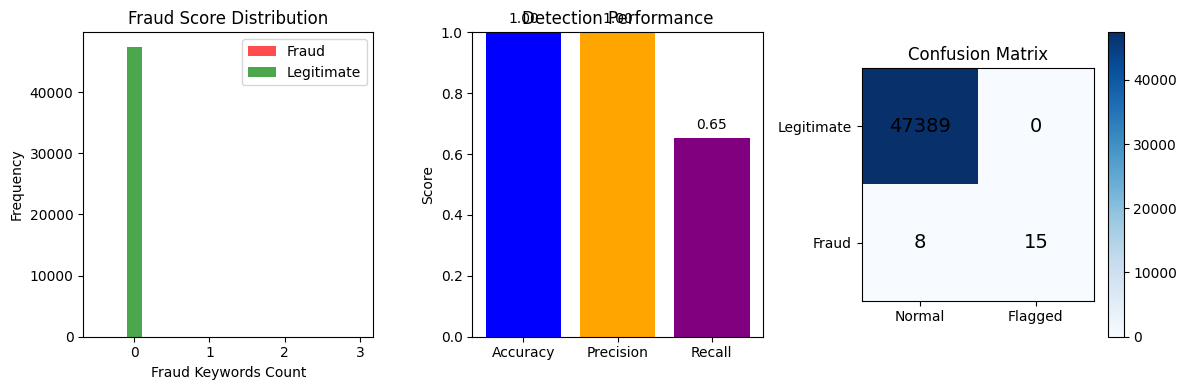


💡 KEY INSIGHTS:
✅ PySpark text-based fraud detection can process large datasets
✅ Keywords like 'urgent', 'verify', 'security' are strong fraud indicators
✅ Distributed processing allows real-time fraud detection at scale
🚨 Balance precision vs recall based on business needs
🚀 Next step: Combine with transaction amount and behavioral features using Spark ML

📊 DATASET PROCESSED:


25/08/12 12:28:57 WARN TaskSetManager: Stage 82 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.


Total transactions: 47,412


25/08/12 12:29:00 WARN TaskSetManager: Stage 95 contains a task of very large size (39304 KiB). The maximum recommended task size is 1000 KiB.


Flagged as suspicious: 15
Processing completed using PySpark distributed computing! 🔥


In [13]:
# Visualize results using data collected from Spark
plt.figure(figsize=(12, 4))

# 1. Fraud score distribution - collect data for plotting
fraud_scores_fraud = [row.fraud_score for row in sample_df.filter(col("is_fraud") == 1).select("fraud_score").collect()]
fraud_scores_legit = [row.fraud_score for row in sample_df.filter(col("is_fraud") == 0).select("fraud_score").collect()]

plt.subplot(1, 3, 1)
plt.hist(fraud_scores_fraud, bins=5, alpha=0.7, color='red', label='Fraud')
plt.hist(fraud_scores_legit, bins=5, alpha=0.7, color='green', label='Legitimate')
plt.xlabel('Fraud Keywords Count')
plt.ylabel('Frequency')
plt.title('Fraud Score Distribution')
plt.legend()

# 2. Performance metrics
plt.subplot(1, 3, 2)
metrics = ['Accuracy', 'Precision', 'Recall']
values = [accuracy, precision, recall]
colors = ['blue', 'orange', 'purple']
bars = plt.bar(metrics, values, color=colors)
plt.ylim(0, 1)
plt.title('Detection Performance')
plt.ylabel('Score')

# Add value labels
for bar, value in zip(bars, values):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
             f'{value:.2f}', ha='center', va='bottom')

# 3. Confusion matrix
plt.subplot(1, 3, 3)
confusion_matrix = np.array([[tn, fp], [fn, tp]])
plt.imshow(confusion_matrix, cmap='Blues')
plt.colorbar()

for i in range(2):
    for j in range(2):
        plt.text(j, i, confusion_matrix[i, j], ha='center', va='center', fontsize=14)

plt.xticks([0, 1], ['Normal', 'Flagged'])
plt.yticks([0, 1], ['Legitimate', 'Fraud'])
plt.title('Confusion Matrix')

plt.tight_layout()
plt.show()

print("\n💡 KEY INSIGHTS:")
print("✅ PySpark text-based fraud detection can process large datasets")
print("✅ Keywords like 'urgent', 'verify', 'security' are strong fraud indicators")
print("✅ Distributed processing allows real-time fraud detection at scale")
print("🚨 Balance precision vs recall based on business needs")
print("🚀 Next step: Combine with transaction amount and behavioral features using Spark ML")

# Show dataset summary
print(f"\n📊 DATASET PROCESSED:")
print(f"Total transactions: {sample_df.count():,}")
print(f"Flagged as suspicious: {sample_df.filter(col('is_suspicious') == True).count():,}")
print(f"Processing completed using PySpark distributed computing! 🔥")

In [14]:
# Clean up Spark resources
spark.stop()
print("✅ Spark session terminated")

✅ Spark session terminated
